In [1]:
import networkx as nx
import pandas as pd
import numpy as np

# Load the dataset
edges_path = "facebook_combined.txt"
edges = pd.read_csv(edges_path, delim_whitespace=True, header=None, names=["source", "target"])

# Remove duplicate edges
edges = edges.drop_duplicates()

# Create the graph
G = nx.from_pandas_edgelist(edges, "source", "target")

# Sampling 40% of the nodes
np.random.seed(42)  # For reproducibility
nodes = list(G.nodes())
nodes_to_keep = np.random.choice(nodes, size=int(0.40 * len(nodes)), replace=False)

# Create a subgraph with the selected nodes
G = G.subgraph(nodes_to_keep).copy()  # Use copy() to create a modifiable graph
nodes = list(G.nodes())

# Randomly select edges to remove (let's remove 10% of the edges)
np.random.seed(42)  # For reproducibility
num_edges_to_remove = int(G.number_of_edges() * 0.1)

# Convert edges to a list to make them 1-dimensional for random selection
edges_list = list(G.edges())
edges_to_remove_indexes = np.random.choice(len(edges_list), size=num_edges_to_remove, replace=False)

# Now select the actual edges to remove based on their index
edges_to_remove = [edges_list[index] for index in edges_to_remove_indexes]

# Remove the selected edges
G.remove_edges_from(edges_to_remove)

# Output the number of edges removed and the remaining number of edges
num_edges_removed = len(edges_to_remove)
num_edges_remaining = G.number_of_edges()

print(f"Number of nodes in the subgraph: {G.number_of_nodes()}")
print(f"Number of edges in the subgraph before removal: {G.number_of_edges() + num_edges_removed}")
print(f"Number of edges removed: {num_edges_removed}")
print(f"Number of edges remaining: {G.number_of_edges()}")

Number of nodes in the subgraph: 1615
Number of edges in the subgraph before removal: 13453
Number of edges removed: 1345
Number of edges remaining: 12108


In [2]:
# Function to calculate Jaccard Coefficient for all pairs of nodes
def jaccard_coefficient(G):
    preds = nx.jaccard_coefficient(G)
    return {(u, v): p for u, v, p in preds}


# Function to calculate Adamic/Adar index for all pairs of nodes
def adamic_adar_index(G):
    preds = nx.adamic_adar_index(G)
    return {(u, v): p for u, v, p in preds}


# Function to calculate number of common neighbors for all pairs of nodes
def common_neighbors(G):
    return {(u, v): len(list(nx.common_neighbors(G, u, v))) for u, v in nx.non_edges(G)}


# Function to calculate Resource Allocation index for all pairs of nodes
def resource_allocation_index(G):
    preds = nx.resource_allocation_index(G)
    return {(u, v): p for u, v, p in preds}


def recommend_nodes_fixed(similarity_df, sample_nodes, metric="Jaccard", top_n=5):
    recommendations = {}
    expanded_df = similarity_df.copy()
    expanded_df[["Node1", "Node2"]] = pd.DataFrame(expanded_df["Edge"].tolist(), index=expanded_df.index)

    for node in sample_nodes:
        node_edges = expanded_df[(expanded_df["Node1"] == node) | (expanded_df["Node2"] == node)]
        sorted_edges = node_edges.sort_values(by=[metric], ascending=False).head(top_n)
        recommended_nodes = sorted_edges.apply(lambda x: x["Node2"] if x["Node1"] == node else x["Node1"], axis=1).tolist()
        recommendations[node] = recommended_nodes

    return recommendations


def generate_predicted_edges(recommendations, node):
    predicted_edges = [(node, recommended_node) for recommended_node in recommendations.get(node, [])]
    return predicted_edges

In [3]:
# Recalculate similarity metrics for the subgraph
jaccard_sim_sub = jaccard_coefficient(G)
adamic_adar_sim_sub = adamic_adar_index(G)
common_neighbors_sub = common_neighbors(G)
resource_allocation_sub = resource_allocation_index(G)

# Convert similarity metrics to DataFrame for easier handling
jaccard_df = pd.DataFrame(list(jaccard_sim_sub.items()), columns=["Edge", "Jaccard"])
adamic_adar_df = pd.DataFrame(list(adamic_adar_sim_sub.items()), columns=["Edge", "Adamic/Adar"])
common_neighbors_df = pd.DataFrame(list(common_neighbors_sub.items()), columns=["Edge", "Common Neighbors"])
resource_allocation_df = pd.DataFrame(list(resource_allocation_sub.items()), columns=["Edge", "Resource Allocation"])

# Merge DataFrames on the 'Edge' column to have all similarities side by side
similarity_df = pd.merge(jaccard_df, adamic_adar_df, on="Edge")
similarity_df = pd.merge(similarity_df, common_neighbors_df, on="Edge", how="outer")
similarity_df = pd.merge(similarity_df, resource_allocation_df, on="Edge", how="outer")

# Sort the DataFrame by all similarity measures in descending order
similarity_df.sort_values(by=["Jaccard", "Adamic/Adar", "Common Neighbors", "Resource Allocation"], ascending=False, inplace=True)

# Show the first few rows of the merged and sorted DataFrame
similarity_df.head()

# calculate recommendations
recommendations_jaccard_fixed = recommend_nodes_fixed(similarity_df, nodes, metric="Jaccard")
recommendations_adamic_adar_fixed = recommend_nodes_fixed(similarity_df, nodes, metric="Adamic/Adar")
recommendations_common_neighbors_fixed = recommend_nodes_fixed(similarity_df, nodes, metric="Common Neighbors")
recommendations_resource_allocation_fixed = recommend_nodes_fixed(similarity_df, nodes, metric="Resource Allocation")

dict(list(recommendations_jaccard_fixed.items())[:5]), dict(list(recommendations_adamic_adar_fixed.items())[:5]), dict(
    list(recommendations_common_neighbors_fixed.items())[:5]
), dict(list(recommendations_resource_allocation_fixed.items())[:5])

# تولید پیوندهای پیش‌بینی شده بر اساس توصیه‌ها برای تمام معیارهای شباهت
all_predicted_edges_jaccard = []
all_predicted_edges_adamic_adar = []
all_predicted_edges_common_neighbors = []
all_predicted_edges_resource_allocation = []

# تولید و افزودن پیوندهای پیش‌بینی شده به لیست‌های مربوطه برای هر معیار
for node in nodes:
    all_predicted_edges_jaccard.extend(generate_predicted_edges(recommendations_jaccard_fixed, node))
    all_predicted_edges_adamic_adar.extend(generate_predicted_edges(recommendations_adamic_adar_fixed, node))
    all_predicted_edges_common_neighbors.extend(generate_predicted_edges(recommendations_common_neighbors_fixed, node))
    all_predicted_edges_resource_allocation.extend(generate_predicted_edges(recommendations_resource_allocation_fixed, node))

# حذف تکراری‌ها از لیست‌های پیوندهای پیش‌بینی شده برای هر معیار
unique_predicted_edges_jaccard = set(all_predicted_edges_jaccard)
unique_predicted_edges_adamic_adar = set(all_predicted_edges_adamic_adar)
unique_predicted_edges_common_neighbors = set(all_predicted_edges_common_neighbors)
unique_predicted_edges_resource_allocation = set(all_predicted_edges_resource_allocation)

# پیدا کردن تطابق‌ها بین پیوندهای پیش‌بینی شده و پیوندهای حذف‌شده برای هر معیار
removed_edges_set = set(edges_to_remove)
matches_jaccard = [edge for edge in unique_predicted_edges_jaccard if edge in removed_edges_set]
matches_adamic_adar = [edge for edge in unique_predicted_edges_adamic_adar if edge in removed_edges_set]
matches_common_neighbors = [edge for edge in unique_predicted_edges_common_neighbors if edge in removed_edges_set]
matches_resource_allocation = [edge for edge in unique_predicted_edges_resource_allocation if edge in removed_edges_set]

# درصد تطابق برای هر معیار
match_percent_jaccard = len(matches_jaccard) / len(removed_edges_set) * 100
match_percent_adamic_adar = len(matches_adamic_adar) / len(removed_edges_set) * 100
match_percent_common_neighbors = len(matches_common_neighbors) / len(removed_edges_set) * 100
match_percent_resource_allocation = len(matches_resource_allocation) / len(removed_edges_set) * 100

# چاپ درصد تطابق برای هر معیار
print(f"Jaccard: {match_percent_jaccard:.2f}%, ({len(matches_jaccard)} out of {len(removed_edges_set)})")
print(f"Adamic/Adar: {match_percent_adamic_adar:.2f}%, ({len(matches_adamic_adar)} out of {len(removed_edges_set)})")
print(
    f"Common Neighbors: {match_percent_common_neighbors:.2f}%, ({len(matches_common_neighbors)} out of {len(removed_edges_set)})"
)
print(
    f"Resource Allocation: {match_percent_resource_allocation:.2f}%, ({len(matches_resource_allocation)} out of {len(removed_edges_set)})"
)

Jaccard: 44.91%, (604 out of 1345)
Adamic/Adar: 46.54%, (626 out of 1345)
Common Neighbors: 45.43%, (611 out of 1345)
Resource Allocation: 47.14%, (634 out of 1345)


In [9]:
import matplotlib.pyplot as plt


def plot_edges(edges):
    plt.figure(figsize=(10, 10))
    plt.plot(edges["source"], edges["target"], "b,")
    plt.xlabel("Source")
    plt.ylabel("Target")
    plt.title("Graph of Edges")
    plt.show()

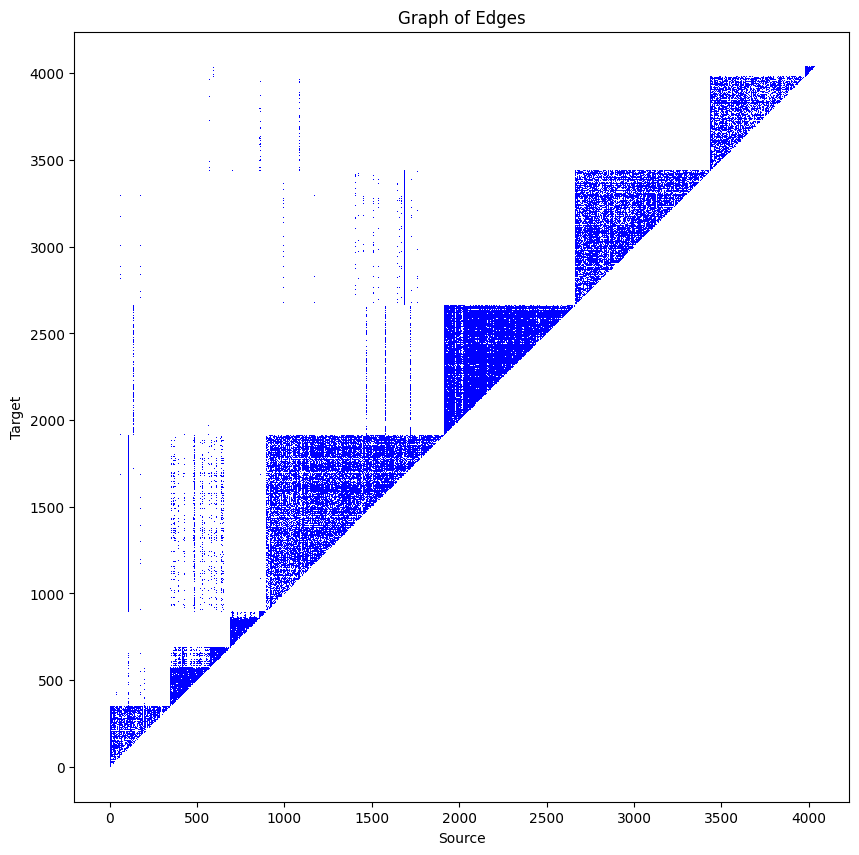

176468


In [26]:
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Load the dataset
edges_path = "facebook_combined.txt"
edges = pd.read_csv(edges_path, delim_whitespace=True, header=None, names=["source", "target"])

plot_edges(edges)

# Remove duplicate edges
edges = edges.drop_duplicates()


# Create the graph
G = nx.from_pandas_edgelist(edges, "source", "target")


# Step 1: Generate negative samples (non-edges) for a balanced dataset
def generate_negative_edges(G, num_neg_samples):
    negative_edges = set()
    while len(negative_edges) < num_neg_samples:
        u, v = np.random.choice(G.nodes(), 2, replace=False)
        if not G.has_edge(u, v):
            negative_edges.add((u, v))
    return list(negative_edges)


# Number of positive samples (existing edges)
num_pos_samples = len(G.edges())
negative_edges = generate_negative_edges(G, num_pos_samples)

# Step 2: Create a balanced dataset
positive_edges = list(G.edges())
positive_labels = [1] * len(positive_edges)
negative_labels = [0] * len(negative_edges)

# Combine positive and negative samples
all_edges = positive_edges + negative_edges
all_labels = positive_labels + negative_labels


# Step 3: Extract features for all samples
def extract_features(G, edge):
    u, v = edge
    return [
        len(list(nx.common_neighbors(G, u, v))),
        list(nx.jaccard_coefficient(G, [(u, v)]))[0][2],
        list(nx.adamic_adar_index(G, [(u, v)]))[0][2],
        list(nx.resource_allocation_index(G, [(u, v)]))[0][2],
    ]


features = [extract_features(G, edge) for edge in all_edges]
print(len(features))



In [20]:
# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, all_labels, test_size=0.3)


# Step 5: Train the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# Step 6: Predict and evaluate the model
predictions = model.predict(X_test)

In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)

print(f"Accuracy: {accuracy:.9f}")
print(f"Precision: {precision:.9f}")
print(f"Recall: {recall:.9f}")
print(f"F1-Score: {f1:.9f}")

Accuracy: 0.978126594
Precision: 0.974492863
Recall: 0.981869796
F1-Score: 0.978167421


In [25]:
# check if the model is overfitting
predictions_train = model.predict(X_train)
accuracy_train = accuracy_score(y_train, predictions_train)
print(f"Accuracy on training set: {accuracy_train:.9f}")

Accuracy on training set: 0.995507055
